# USPS Handwritten Digits

Downloads from [csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html) and expands into individual PNG files in `${KERAS_HOME:-~/.keras}`. Originally from [machinecurve/extra_keras_datasets](https://github.com/machinecurve/extra_keras_datasets/blob/master/extra_keras_datasets/usps.py).

Note that the source cites this as [Hull 1994](https://ieeexplore.ieee.org/document/291440); but it's actually Yann LeCun's from [_Backpropagation Applied to Handwritten Zip Code Recognition_](http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf) (1989). Also check out Andrej Karpathy's [reproduction](https://github.com/karpathy/lecun1989-repro).

In [1]:
import bz2
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from sklearn.datasets import load_svmlight_file
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow.keras.utils import get_file
from yellowbrick.classifier import ConfusionMatrix

In [2]:
# extract the archive
def bz2_to_svm(path):
    with bz2.BZ2File(path) as bz:
        data = bz.read()

    new_path = path.replace("bz2", "svm")
    with open(new_path, "wb") as f:
        f.write(data)

    return new_path


# load the libsvm file into a numpy array
def svm_to_numpy(path):
    data = load_svmlight_file(path)

    # reshape data
    (X, y) = (data[0].toarray(), data[1])
    X = X.reshape(X.shape[0], 16, 16)

    # labels are 1.0-10.0; make 0-9
    y = y - 1
    y = y.astype(int)

    return (X, y)


# save images to disk
def save_images(images, labels, directory, force=False):
    if not os.path.exists(directory):
        os.makedirs(directory)

    # count:
    #   ls -1 ~/.keras/datasets/usps_train | wc -l # 7291
    #   ls -1 ~/.keras/datasets/usps_test | wc -l # 2007
    for i, (image, label) in enumerate(zip(images, labels)):
        filepath = os.path.join(directory, f"{label}_{i:04d}.png")
        if not os.path.exists(filepath) or force:
            image = (image * 255).astype(np.uint8)
            img = Image.fromarray(image, mode="L")
            img.save(filepath)


# download and prepare the dataset
def fetch_digits(force=False):
    # base_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass"
    base_url = "https://lab.aef.me/files/data"
    path_train = get_file("usps_train.bz2", origin=f"{base_url}/usps.bz2", force_download=force)
    path_test = get_file("usps_test.bz2", origin=f"{base_url}/usps.t.bz2", force_download=force)

    train = bz2_to_svm(path_train)
    test = bz2_to_svm(path_test)

    (X_train, y_train) = svm_to_numpy(train)
    (X_test, y_test) = svm_to_numpy(test)

    save_images(X_train, y_train, path_train[:-4], force)
    save_images(X_test, y_test, path_test[:-4], force)


# load the dataset
def load_digits(force=False):
    fetch_digits(force=force)

    keras_home = os.getenv("KERAS_HOME", "~/.keras")
    path_train = os.path.expanduser(f"{keras_home}/datasets/usps_train.svm")
    path_test = os.path.expanduser(f"{keras_home}/datasets/usps_test.svm")

    (X_train, y_train) = svm_to_numpy(path_train)
    (X_test, y_test) = svm_to_numpy(path_test)

    return (X_train, y_train), (X_test, y_test)

In [3]:
# load
(X_train, y_train), (X_test, y_test) = load_digits()

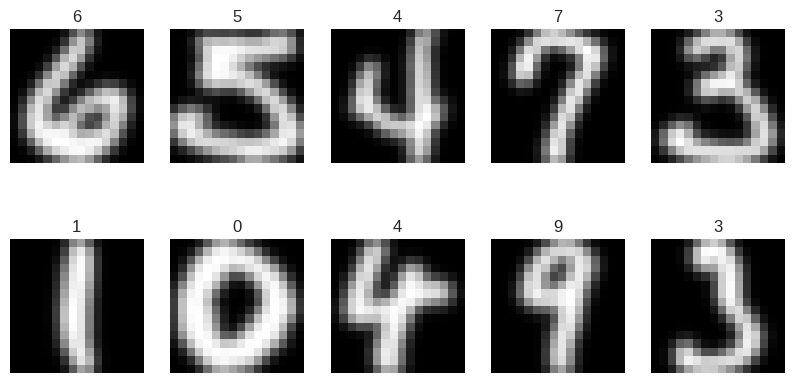

In [4]:
# display first 5 from training set and last 5 from test set
plt.figure(figsize=(10, 5))
for i in range(5):
    # 2 rows, 5 columns, starting at 1
    plt.subplot(2, 5, i + 1)
    plt.title(y_train[i])
    plt.imshow(X_train[i], cmap="gray")
    plt.axis("off")
    # starting at 6
    plt.subplot(2, 5, i + 6)
    plt.title(y_test[-1 - i])
    plt.imshow(X_test[-1 - i], cmap="gray")
    plt.axis("off")
plt.show()

In [5]:
# don't copy if they're already there
if not os.path.exists("usps.bz2") or not os.path.exists("usps.t.bz2"):
    keras_home = os.getenv("KERAS_HOME", "~/.keras")
    path_train = os.path.expanduser(f"{keras_home}/datasets/usps_train.bz2")
    path_test = os.path.expanduser(f"{keras_home}/datasets/usps_test.bz2")
    path_dest = os.getcwd()

    shutil.copy(path_train, os.path.join(path_dest, "usps.bz2"))
    shutil.copy(path_test, os.path.join(path_dest, "usps.t.bz2"))

## SVM Classifier

Given that we got this from the libsvm page, let's build a multi-class SVM classifier using the one-vs-one (OVO) strategy. We'll use `StandardScaler` to normalize the data and Yellowbrick to visualize the confusion matrix.

In [6]:
# flatten from matrices to vectors
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# randomstate instance
rs = np.random.RandomState(42)

# fit
model = make_pipeline(StandardScaler(), SVC(decision_function_shape="ovo", random_state=rs))
model.fit(X_train_flat, y_train)

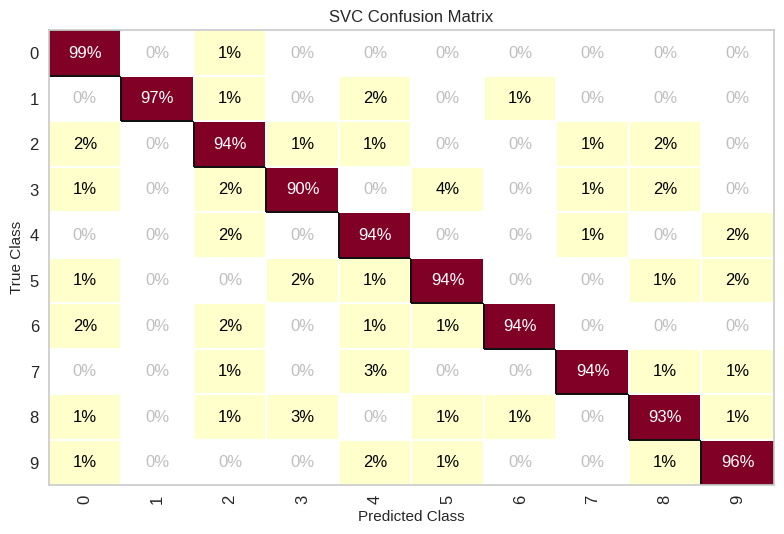

In [7]:
# visualize confusion matrix
cm = ConfusionMatrix(model, percent=True)
cm.fit(X_train_flat, y_train)
cm.score(X_test_flat, y_test)
cm.show()
plt.show()